# **MAAS User Interface**

Este notebook detalla la interfaz a utilizar para ejecutar MAAS. Funciona en Google Colab y en JupyterLab.

## Consideraciones
### Instalar
- numpy
- IPython
- soundfile
- scipy
- matplotlib
- sounddevice
- ipython-autotime

### Si ejecuta en JupyterLab
- Le preguntará si gusta grabar desde el micrófono (presione ENTER); de no ser así, escriba el nombre de un archivo WAV a 44100 Hz (con extensión), colocado en ./samples/ y presione ENTER.
- Si cargó un archivo de audio, le preguntará si gusta guardar el CSV generado con MAAS_filter() en ./database/ para posteriores comparaciones.
- Si clonó el repositorio, funciona out of the box. Recuerde instalar toda la paquetería requerida y verificar que MAAS_Filters.ipynb se encuentre en el mismo directorio.

### Si ejecuta en Colab
- Puede utilizar el micrófono y grabar (si la sesión es nueva, puede que requiera de dos intentos por cuestiones de permisos).
- No se guardará ningún CSV.
- Debe cargar la base de datos a la raíz de la sesión (\[/content\]/*.csv) para realizar la comparación.
- Debe cargar el módulo MAAS_Filters.ipynb a la raíz de la sesión (\[/content\]/MAAS_Filters.ipynb).

## Autores
- Diego Casta - 35705
- Mauricio Alcántar - 35860
- David Santana - 35967

## **Librerías**

In [1]:
# Intentar cargar la librería de Google Colab.
try:
    from google.colab import output
except ImportError:
    pass

# Decidir si estamos en colab.
IN_COLAB = None
if 'google.colab' in str(get_ipython()):
  IN_COLAB = True
  print('Ejecutándose en Colab')
else:
  IN_COLAB = False
  print('Ejecutándose localmente')

# Si es así, instalar librerías automáticamente.
if IN_COLAB:
  !pip install ipython-autotime numpy IPython soundfile scipy matplotlib sounddevice

Ejecutándose localmente


In [2]:
# Cargar métrica de tiempo para las celdas
%load_ext autotime

time: 0 ns (started: 2024-11-30 00:56:05 -08:00)


In [3]:
# Importar librerías
import numpy as np
from base64 import b64decode
from IPython.display import Javascript
import IPython.display as ipd
import io
import soundfile as sf
from scipy import signal as sig
from scipy.io import wavfile as wav
from os import listdir
import sounddevice as sd
import matplotlib.pyplot as plt
import math

time: 750 ms (started: 2024-11-30 00:56:05 -08:00)


## **Lectura de archivo**

In [4]:
# Código JavaScript para grabar desde el micrófono del navegador en Colab. Se ignora si el entorno no es Colab.
RECORD = None if not IN_COLAB else """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time));

const b2text = blob => new Promise(resolve => {
  const reader = new FileReader();
  reader.onloadend = e => resolve(e.srcElement.result);
  reader.readAsDataURL(blob);
});

var record = time => new Promise(async resolve => {
  const stream = await navigator.mediaDevices.getUserMedia({ audio: true });
  const audioContext = new AudioContext({ sampleRate: 44100 });
  const source = audioContext.createMediaStreamSource(stream);
  const recorder = new MediaRecorder(stream);
  let chunks = [];

  recorder.ondataavailable = e => chunks.push(e.data);
  alert("Presiona 'aceptar' para empezar la grabación.");
  recorder.start();
  await sleep(time);

  recorder.onstop = async () => {
    const blob = new Blob(chunks, { type: 'audio/ogg; codecs=opus' });
    const arrayBuffer = await blob.arrayBuffer();
    const audioBuffer = await audioContext.decodeAudioData(arrayBuffer);

    // Convert to WAV format
    const wavBlob = encodeWAV(audioBuffer, 44100, 16);
    const wavText = await b2text(wavBlob);
    resolve(wavText);

    // Clean up
    stream.getTracks().forEach(track => track.stop());
    audioContext.close();
  };

  recorder.stop();
});

// WAV encoding function
function encodeWAV(audioBuffer, sampleRate, bitDepth) {
  const numChannels = audioBuffer.numberOfChannels;
  const length = audioBuffer.length * numChannels * (bitDepth / 8);
  const buffer = new ArrayBuffer(44 + length);
  const view = new DataView(buffer);

  // WAV header
  writeString(view, 0, 'RIFF');
  view.setUint32(4, 36 + length, true);
  writeString(view, 8, 'WAVE');
  writeString(view, 12, 'fmt ');
  view.setUint32(16, 16, true);  // Format chunk length
  view.setUint16(20, 1, true);   // PCM format
  view.setUint16(22, numChannels, true);
  view.setUint32(24, sampleRate, true);
  view.setUint32(28, sampleRate * numChannels * (bitDepth / 8), true); // Byte rate
  view.setUint16(32, numChannels * (bitDepth / 8), true); // Block align
  view.setUint16(34, bitDepth, true); // Bits per sample
  writeString(view, 36, 'data');
  view.setUint32(40, length, true);

  // Write PCM samples
  let offset = 44;
  for (let channel = 0; channel < numChannels; channel++) {
    const data = audioBuffer.getChannelData(channel);
    for (let i = 0; i < data.length; i++, offset += 2) {
      const sample = Math.max(-1, Math.min(1, data[i]));
      view.setInt16(offset, sample < 0 ? sample * 0x8000 : sample * 0x7FFF, true);
    }
  }

  return new Blob([view], { type: 'audio/wav' });
}

function writeString(view, offset, string) {
  for (let i = 0; i < string.length; i++) {
    view.setUint8(offset + i, string.charCodeAt(i));
  }
}
"""

# Función para grabar desde el micrófono local en JupyterLab. Retorna los datos y la tasa de muestreo.
def record_lab(duration=5, sample_rate=44100, channels=1):
    print("Grabando...")
    recording = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=channels, dtype='int16')
    sd.wait()
    print("Grabación terminada.")
    return recording, sample_rate

# Función máscara para grabar en JupyterLab o Colab. Retorna un BytesIO con los datos del audio grabado.
def record(sec=10):
  if (IN_COLAB):
    output.eval_js(RECORD)
    sec += 1
    s = output.eval_js('record(%d)' % (sec*1000))
    print("Grabación terminada")
    return io.BytesIO(b64decode(s.split(',')[1]))
  else:
    recording, sample_rate = record_lab(duration=sec)
    byte_io = io.BytesIO()
    wav.write(byte_io, sample_rate, recording)
    byte_io.seek(0)
    return byte_io

time: 0 ns (started: 2024-11-30 00:56:06 -08:00)


In [5]:
FILENAME = '' if IN_COLAB else input("Presiona ENTER para grabar o introduce el nombre de un archivo WAV colocado en ./samples/")

Presiona ENTER para grabar o introduce el nombre de un archivo WAV colocado en ./samples/ 


time: 3.53 s (started: 2024-11-30 00:56:06 -08:00)


In [6]:
audio = record(10) if FILENAME == '' else open('./samples/' + FILENAME, 'rb') # Si no hay nombre de archivo, grabamos.

Grabando...
Grabación terminada.
time: 10.1 s (started: 2024-11-30 00:56:09 -08:00)


In [7]:
ipd.display(ipd.Audio(audio.read())) # Mostrar el audio a procesar.

time: 16 ms (started: 2024-11-30 00:56:19 -08:00)


In [8]:
audio.seek(0) # Retornar el cabezal del audio a 0.
data, sr = sf.read(audio) # Obtener de vuelta los datos y tasa de muestreo.
if (data.ndim == 2): data = data.mean(axis=1).astype(data.dtype) # Si hay dos canales, hacer mono.
print("La tasa de muestreo es {0}Hz".format(sr)) # Verificar tasa de muestreo.

La tasa de muestreo es 44100Hz
time: 0 ns (started: 2024-11-30 00:56:19 -08:00)


In [9]:
# Ejecutar la definición de MAAS_filter(), ubicada en el módulo MAAS_Filters.ipynb.
if (IN_COLAB):
  %run /content/MAAS_Filters.ipynb # En Colab, se busca en el directorio content (raíz).
else:
  %run ./MAAS_Filters.ipynb # En JupyterLab, se busca en el mismo directorio.

time: 235 ms (started: 2024-11-30 00:56:19 -08:00)


In [10]:
SHOULD_SAVE = False if IN_COLAB or FILENAME == '' else input('¿Guardar ./database/' + FILENAME[0:-3] + 'csv? [y/N]').lower() == 'y'

time: 0 ns (started: 2024-11-30 00:56:20 -08:00)


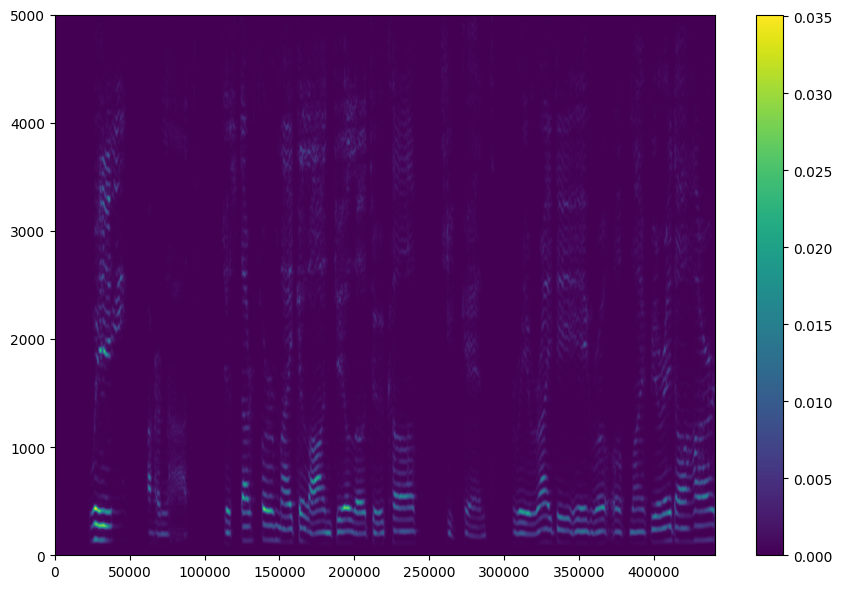

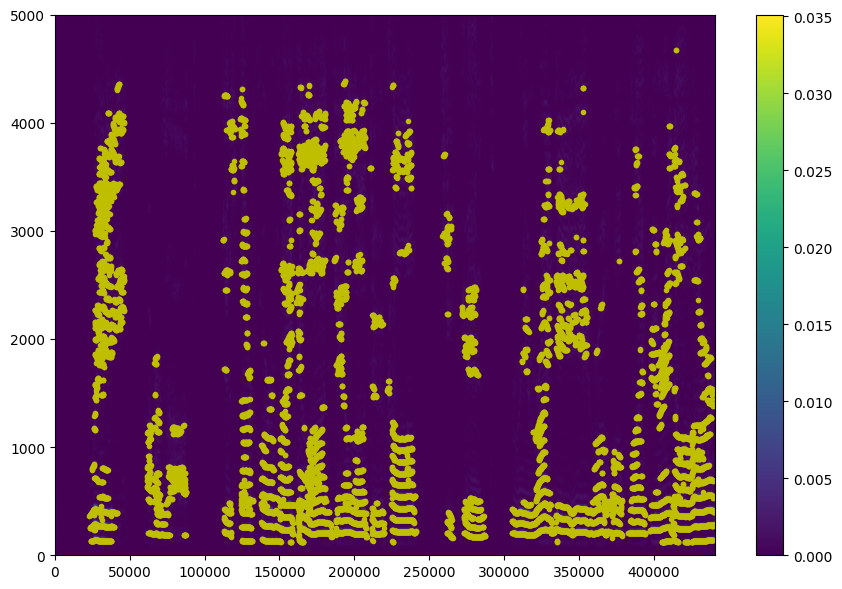

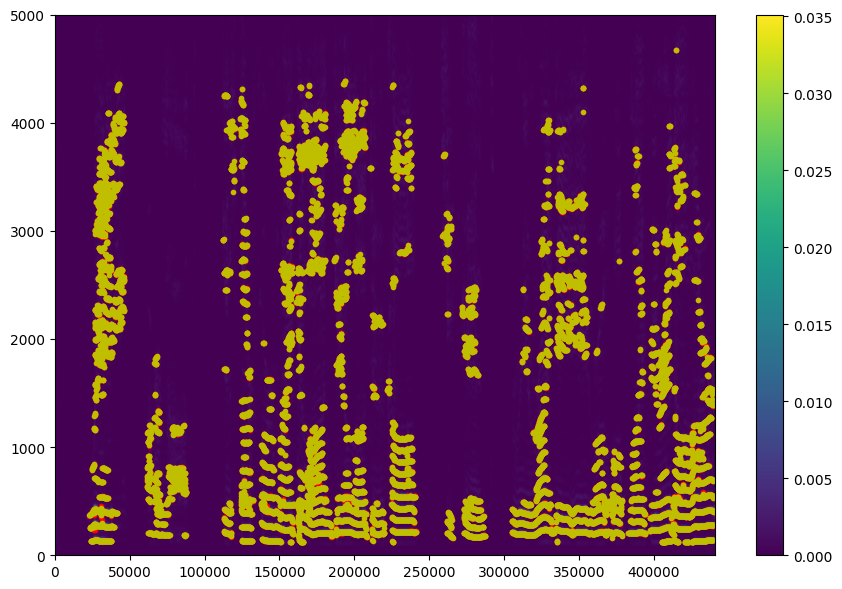

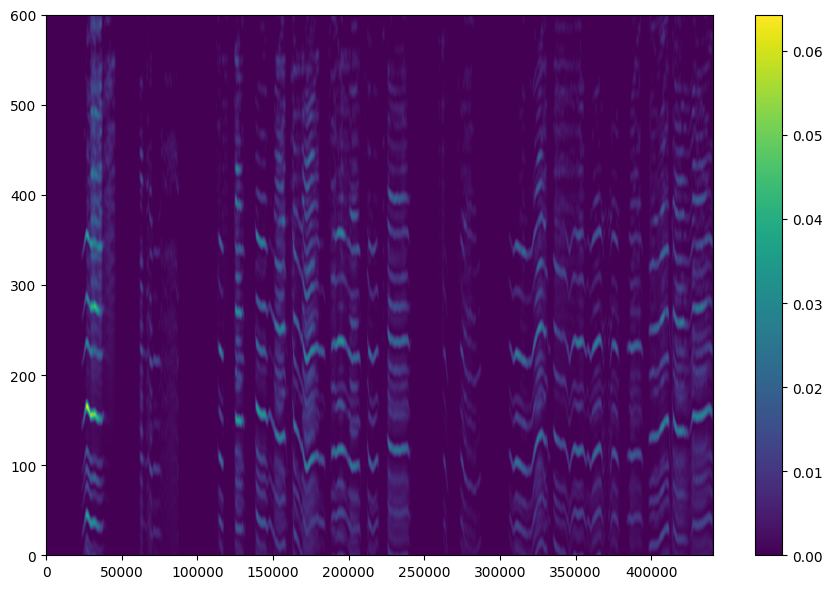

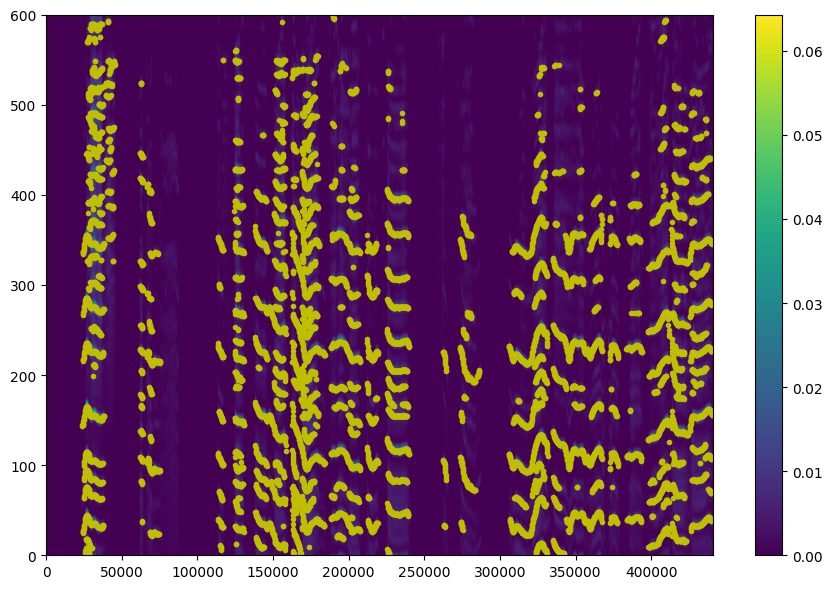

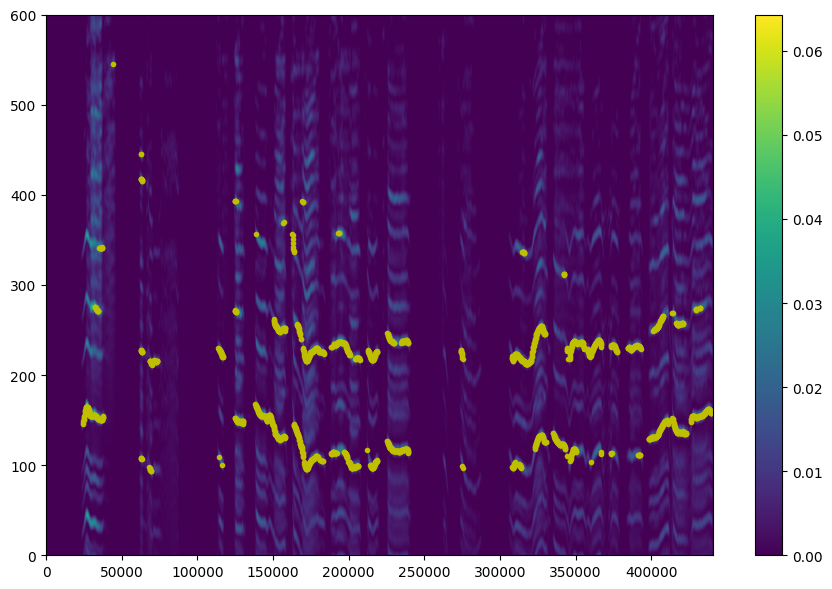

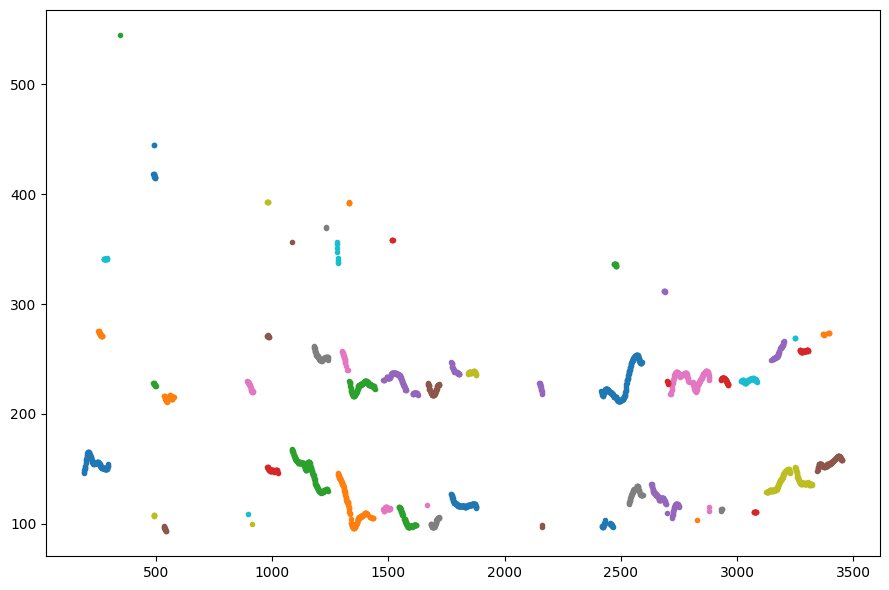

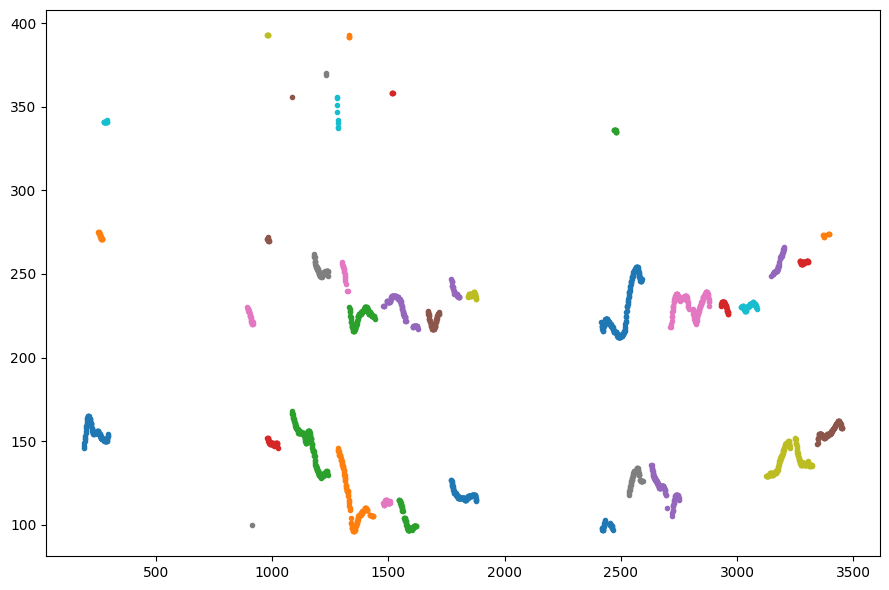

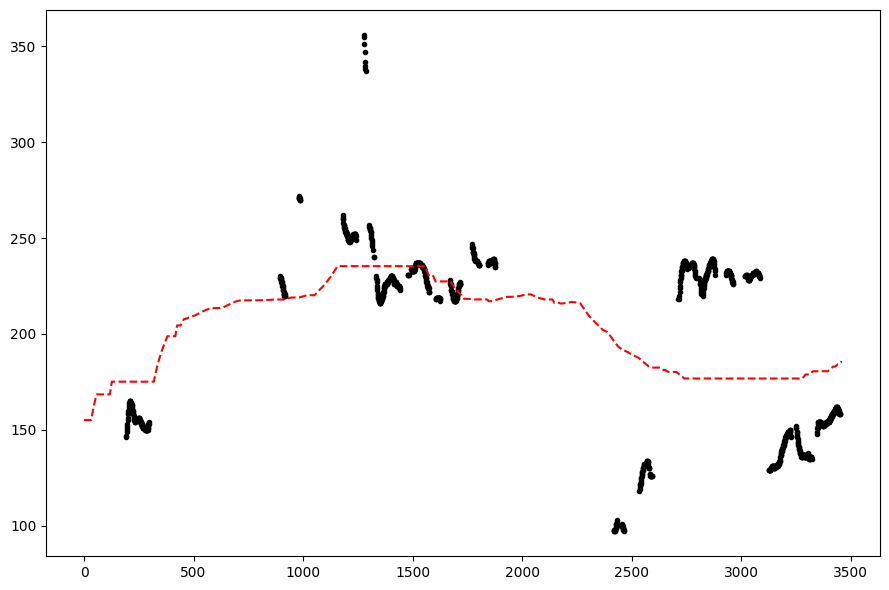

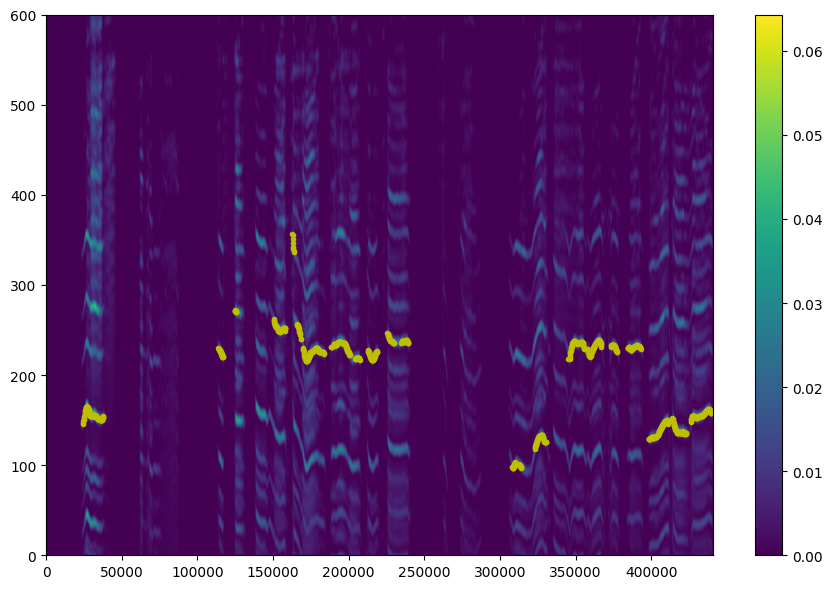

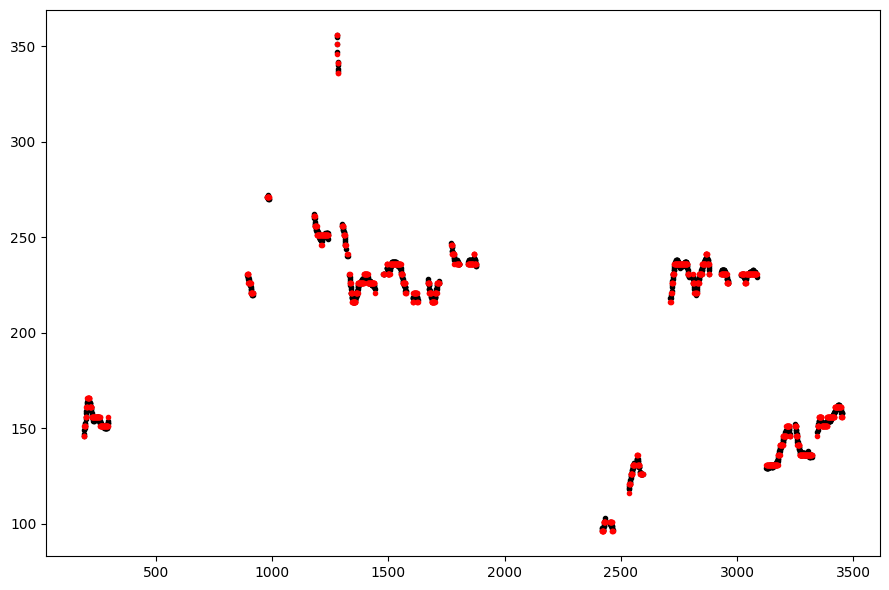

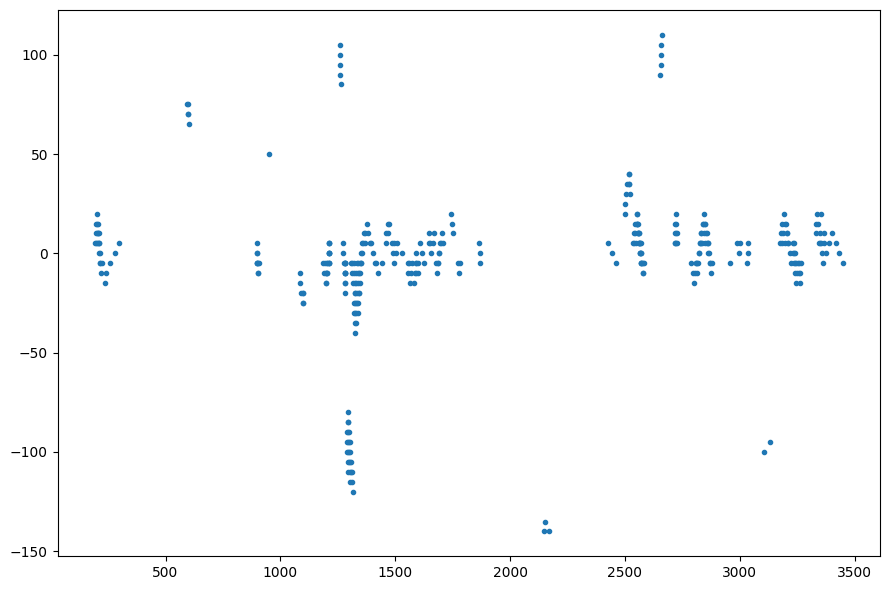

time: 40.1 s (started: 2024-11-30 00:56:20 -08:00)


In [11]:
filtered = MAAS_filter(data, sr, None if (not SHOULD_SAVE) else './database/' + FILENAME[0:-3] + 'csv') # Ejecutar filtros.

In [12]:
filtered, filtered.shape[1] # Mostrar datos filtrados.

(array([[ 193.5,  196. ,  197.5,  200. ,  204.5,  209. ,  198.5,  200. ,
          202.5,  207. ,  211.5,  201.5,  204. ,  208.5,  213. ,  206.5,
          211. ,  215.5,  215.5,  220. ,  238. ,  224.5,  242.5,  260.5,
          278. ,  295.5,  595. ,  596.5,  597. ,  598. ,  602.5,  896.5,
          897. ,  898. ,  902.5,  897.5,  898.5,  903. ,  899.5,  904. ,
          908.5,  948.5, 1083.5, 1085.5, 1090. , 1099. , 1099.5, 1100. ,
         1100.5, 1183.5, 1188. , 1197. , 1197.5, 1198. , 1198.5, 1192.5,
         1201.5, 1202. , 1202.5, 1203. , 1210.5, 1211. , 1211.5, 1212. ,
         1211.5, 1212. , 1212.5, 1212.5, 1213. , 1213.5, 1259.5, 1260.5,
         1261. , 1261.5, 1262.5, 1271.5, 1274.5, 1277.5, 1282.5, 1279.5,
         1280. , 1280.5, 1281.5, 1290.5, 1293.5, 1296.5, 1301.5, 1280.5,
         1281. , 1282. , 1291. , 1294. , 1297. , 1302. , 1281.5, 1282.5,
         1291.5, 1294.5, 1297.5, 1302.5, 1283.5, 1292.5, 1295.5, 1298.5,
         1303.5, 1308. , 1293.5, 1296.5, 1299.5, 13

time: 16 ms (started: 2024-11-30 00:57:00 -08:00)


In [13]:
# Función para ejecutar una regresión lineal sobre los pares de tiempo e intervalos.
def LinearRegressionMAAS(x, y, details=False):
    n = x.size
    xS = sum(x)
    yS = sum(y)
    x2 = sum(x**2)
    y2 = sum(y**2)
    xy = sum(x*y)
    
    # Cálculo de coeficientes
    a1 = ((n*xy) - (xS*yS)) / ((n*x2) - (xS**2))
    a0 = np.mean(y) - (a1 * np.mean(x))

    # Ajuste lineal
    f = a0 + (a1 * x)

    # Métrica de R^2
    RSS = sum((y - f)**2)
    TSS = sum((y - np.mean(y))**2)
    R2 = 0
    if TSS: R2 = 1 - (RSS / TSS)

    # Graficación
    if details:
        plt.plot(x, f, 'bo-')
        plt.plot(x ,y , 'ko')
        plt.title("Window")
        plt.show()
        print(f"y = {a0:.4f} + {a1:.4f}x")
    print(f"R² = {R2:.6f}")
    
    return R2

time: 0 ns (started: 2024-11-30 00:57:00 -08:00)


In [14]:
# Función para analizar ventana por ventana
def SlidingWindowRegression(recording_song, test_song, step, silent=True):
    rec_times, rec_intervals = recording_song[0], recording_song[1]
    test_times, test_intervals = test_song[0], test_song[1]
    window_size = rec_times[-1] - rec_times[0]
    step_size = np.floor(window_size / step)
    R2_arr = np.zeros(0)
    count = 0

    window_start = 0
    window_stop = 0
    while window_stop < test_times[-1]:
        window_stop = window_start + window_size
        window_mask = (test_times >= window_start) & (test_times <= window_stop)
        cur_times = test_times[window_mask]
        cur_intervals = test_intervals[window_mask]

        rec_pairs = np.zeros(0)
        test_pairs = np.zeros(0)
        for i in range(rec_times.size):
            inter_mask = abs(cur_intervals - rec_intervals[i]) <= 5
            inter_mask = inter_mask & (abs(cur_intervals - rec_intervals[i]) >= 5)
            new_pairs = cur_times[inter_mask]
            test_pairs = np.append(test_pairs, new_pairs)
            rec_pairs = np.append(rec_pairs, [rec_intervals[i]]*new_pairs.size)

        count += 1
        window_start += step_size

        if test_pairs.size:
            R2 = LinearRegressionMAAS(rec_pairs, test_pairs, details=not silent)
            R2_arr = np.append(R2_arr, R2)
            if not silent: print(f'Window {count} done successfully.')
        else:
            if not silent: print(f'Window {count} done, no pairs found.')
    
    if R2_arr.size:
        
        return max(R2_arr[R2_arr != 1.0])
    else:
        if not silent: print("Zero matches.\n")
        return 0

time: 0 ns (started: 2024-11-30 00:57:00 -08:00)


In [15]:
# Función para obtener todos los CSVs del directorio de la base de datos.
def get_database():
    filenames = listdir("/content/" if IN_COLAB else "./database/")
    return [ filename for filename in filenames if filename.endswith(".csv") ]

time: 16 ms (started: 2024-11-30 00:57:00 -08:00)


In [16]:
# Función para comparar dos audios filtrados.
def compare(filtered_song, db_obj, silent=True):
    test_song = np.transpose(np.genfromtxt(("/content/" if IN_COLAB else "./database/") + db_obj, delimiter=",", skip_header=1))

    print("Testing against:", db_obj)
    
    R2 = SlidingWindowRegression(filtered_song, test_song, 3, silent=silent)
    
    if R2:
        print("Best R²:", R2)
    else:
        if not silent: print(f"Zero correlation found for {db_obj}.")
    return R2

time: 0 ns (started: 2024-11-30 00:57:00 -08:00)


In [17]:
database = get_database() # Obtener la base de datos.
results = {} # Objeto para almacenar resultados.
for SONG in database: # Para cada canción de la base de datos...
    results[SONG] = compare(filtered, SONG) # ... comparar con el audio filtrado.

identified_song = max(results, key=results.get)[0:-4]
identified_song_name = ' '.join([str.capitalize() for str in identified_song.split('_')])
# Imprimir resultado.
print(f"La canción identificada fue {identified_song_name}")

Testing against: bloody_mary.csv
R² = 0.001205
R² = 0.001205
R² = 0.472269
R² = 0.086647
R² = 0.000453
R² = 0.006992
R² = 0.004987
R² = 0.001060
R² = 0.001371
R² = 0.004691
R² = 0.002345
R² = 0.012464
R² = 0.001267
R² = 0.003472
R² = 0.000381
R² = 0.004068
R² = 0.000430
R² = 0.000851
R² = 0.003304
R² = 0.010146
R² = 0.033681
R² = 0.006180
R² = 0.019219
R² = 0.000168
R² = 0.117643
R² = 0.169240
R² = 0.118064
R² = 0.031206
R² = 0.021211
R² = 0.000652
R² = 0.002992
R² = 0.000275
R² = 0.001277
R² = 0.000017
R² = 0.005147
R² = 0.000003
R² = 0.000149
R² = 0.000029
R² = 0.000260
R² = 0.002860
R² = 0.000791
R² = 0.011306
R² = 0.000947
R² = 0.011325
R² = 0.019442
R² = 0.050199
R² = 0.009830
R² = 0.009830
R² = 0.000072
R² = 0.000028
R² = 0.076265
R² = 0.216316
R² = 0.019932
R² = 0.005125
R² = 0.001748
R² = 0.001692
R² = 0.020924
R² = 0.009307
R² = 0.009765
R² = 0.011662
R² = 0.000038
R² = 0.011846
R² = 0.000747
R² = 0.000244
R² = 0.026209
R² = 0.019019
R² = 0.012810
R² = 0.001693
R² = 0.000272
R